In [56]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [57]:
import torch, torch.nn as nn, torch.functional as F, torch.utils.data as data, torchnet as tnt
import torchvision, numpy as np, os
import matplotlib.pyplot as plt, fastai
from fastai.conv_learner import ConvnetBuilder
from fastai.model import resnext50, resnet34
from fastai.dataset import BaseDataset
import nvvl, time
import sys, os
from tqdm import tqdm
from fastai.metrics import accuracy
from torch.utils.data import WeightedRandomSampler
import random

In [58]:
#Adding layer.freeze and layer.unfreeze capability to nn.Module layers

def freeze(self):
    for param in self.parameters(): param.requires_grad=False
def unfreeze(self):
    for param in self.parameters(): param.requires_grad=True

nn.Module.freeze=freeze
nn.Module.unfreeze=unfreeze

In [4]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"); device

device(type='cuda', index=0)

In [5]:
PATH="/home/sufiyan/Common_data/mtp2/dataset/OLD/100_vids/"
PATH_L_Vids=PATH+"LEFT/"
PATH_L=PATH+"LEFT_data/"
PATH_L_L=PATH+"LEFT_labels/"
PATH_R_Vids=PATH+"RIGHT/"
PATH_R=PATH+"RIGHT_data/"
PATH_R_L=PATH+"RIGHT_labels/"

In [6]:
#string_to_int and int_to_string mapping
stoi={"w":0, "a":1, "d":2}; itos={0:"Clear", 1:"Left", 2:"Right"}

In [7]:
[stoi[key] for key in ["w", "a", "d"]]

[0, 1, 2]

In [8]:
def getLabelFileName(vidFileName):
    """Parse the labelFileName for a given videoFileName"""
    vidName=vidFileName.split("/")[-1]
    labelName=".".join(vidName.split(".")[:-1]+["npy"])
    if vidFileName.split("/")[-2]=="RIGHT_data":
        labelFileName=PATH_R_L+labelName
    elif vidFileName.split("/")[-2]=="LEFT_data":
        labelFileName=PATH_L_L+labelName
    else: raise ValueError(f"Passed videoFile {vidFileName} has non recognizable parent folder")
    return labelFileName

def get_label(vidFileName, frame_num, _=None):
        labelFileName=getLabelFileName(vidFileName)
        labels=np.load(labelFileName)
        try: return stoi[labels[frame_num]]
        except: return stoi[labels[-1]]

In [9]:
#redundent class as weighted Random Sampler was used below
class frameSampler(torch.utils.data.Sampler):
    def __init__(self, data_source, fps=3, source_fps=25):
        self.fps=fps
        self.data_source = data_source
        
    def __iter__(self):
        samples=[num for num in self.data_source if (num%(self.fps+np.random.randint(-2,3))==0)] 
        np.random.shuffle(samples)
        return iter(samples)

    def __len__(self):
        return len(self.data_source)

In [10]:
class oneVidDataset(BaseDataset):
    def __init__(self, fileName, get_label=None):
        self.fileName=fileName
        self.get_label=get_label
    
    def __getitem__(self,idx):
        #skipping the first and last 125 frames.
        idx+=125
        x=np.load(self.fileName)[idx]
        x=np.squeeze(x)     #extra 1 dimention removed if any
        if len(x.shape)==2 : x=np.dstack((x,x,x)) #id image is 1 channel, make it 3 channel
        x=np.rollaxis(x, 2)   #Make the images channel first
        x=x[:,:224,:224].astype("float32")
        return (x, self.get_label(self.fileName, idx))
    
    def get_y(self, idx):
        return self.get_label(self.fileName, idx+125)
    
    def __len__(self):
        return len(np.load(self.fileName))-250 #skiping first and last 125 frames

In [11]:
class ConcatDatasetWithWeights(torch.utils.data.ConcatDataset):
    def __init__(self, fileNames):
        self.fileNames=fileNames
        datasets=[oneVidDataset(fileName, get_label=get_label) for fileName in fileNames]
        super().__init__(datasets)
    
    @staticmethod
    def fixLabelLength(labels, dataset):
        labels=list(labels)
        while len(labels)<len(dataset):
            labels+=labels[-1]
        while len(labels)>len(dataset):
            labels.pop() #remove last extra element
        return labels
    
    def get_y(self, idx):
        import bisect
        dataset_idx = bisect.bisect_right(self.cumulative_sizes, idx)
        if dataset_idx == 0:
            sample_idx = idx
        else:
            sample_idx = idx - self.cumulative_sizes[dataset_idx - 1]
        return self.datasets[dataset_idx].get_y(sample_idx)
    
    def getWeights(self):
        allLabels=[self.get_y(i) for i in range(self.__len__())]
        classes=set(allLabels)                     #will return all classes
        counts = [allLabels.count(someClass) for someClass in classes]
        allLabels=[1/counts[label] for label in allLabels] #convert labels to weights as weight=1/count[label]
        return allLabels        

In [12]:
leftVids =[PATH_L+fileName for fileName in os.listdir(PATH_L) if os.path.isfile(PATH_L+fileName)]
rightVids=[PATH_R+fileName for fileName in os.listdir(PATH_R) if os.path.isfile(PATH_R+fileName)]
trainVids=leftVids[:55]+rightVids[:55]
validVids=leftVids[55:]+rightVids[55:]

In [13]:
trainDataset=ConcatDatasetWithWeights(trainVids)
validDataset=ConcatDatasetWithWeights(validVids)

In [305]:
len(trainDataset)

25918

In [111]:
train_weights=trainDataset.getWeights()
train_weights=np.asarray(train_weights)
valid_weights=validDataset.getWeights()
valid_weights=np.asarray(valid_weights)
weights=np.asarray([train_weights, valid_weights])
np.save("./tmp/WeightedRandomSamplers_Weights_13Oct", weights)

In [81]:
print(f"Total Weights: {len(weights)}")
#Weights for Clear, Left and Right Respectively.
print(f"Unique Weights: {set(weights)}")

Total Weights: 25918
Unique Weights: {3.9912193175014965e-05, 0.002331002331002331, 0.002304147465437788}


In [14]:
train_weights, valid_weights=np.load("./tmp/WeightedRandomSamplers_Weights_13Oct.npy")

In [15]:
len(train_weights), len(valid_weights)

(25918, 3458)

In [16]:
class customWeightedRandomSampler(torch.utils.data.Sampler):
    def __init__(self, weights, num_samples, replacement=True):
        import random
        from torch._six import int_classes as _int_classes
        if not isinstance(num_samples, _int_classes) or isinstance(num_samples, bool) or \
                num_samples <= 0:
            raise ValueError("num_samples should be a positive integeral "
                             "value, but got num_samples={}".format(num_samples))
        if not isinstance(replacement, bool):
            raise ValueError("replacement should be a boolean value, but got "
                             "replacement={}".format(replacement))
        self.weights = weights
        self.num_samples = num_samples
        self.replacement = replacement        
        
    def __iter__(self):
        return iter(random.choices(list(range(len(self.weights))), weights=self.weights, k=self.num_samples))

    def __len__(self):
        return self.num_samples

In [17]:
trainLoader=torch.utils.data.DataLoader(trainDataset, batch_size=32, sampler=customWeightedRandomSampler(train_weights, len(train_weights)), drop_last=True, num_workers=1)
validLoader=torch.utils.data.DataLoader(validDataset, batch_size=32, sampler=customWeightedRandomSampler(valid_weights, len(valid_weights)), drop_last=True, num_workers=1)

In [18]:
modelData=fastai.dataset.ModelData(path=".", trn_dl=trainLoader, val_dl=validLoader)

In [19]:
model=ConvnetBuilder(resnext50, c=3, is_multi=False, is_reg=False, pretrained=True)
[layer.freeze() for i,layer in enumerate(model.model.children()) if i<12] #freezing pretrained layers
[layer.unfreeze() for i,layer in enumerate(model.model.children()) if i>=12] #unfreezing fc layers
learner=fastai.learner.Learner(modelData, model, opt_fn=torch.optim.Adam, models_name="First_Model", crit=torch.nn.CrossEntropyLoss(), metrics=[accuracy])

Below are the labels even after using `torch.utils.data.WeightedRandomSampler`
Hence the need to write my own `customWeightedRandomSampler` class that samples equally from all the classes rather than according to weights as it doesn't help as seen below.

In [34]:
#Distribution of samples according to Labels
for x,y in trainLoader:
    print(y)
    break

tensor([2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 0, 2, 2, 1, 1, 1, 0, 1, 0, 0, 0, 0, 2,
        2, 0, 2, 1, 1, 1, 1, 1, 2, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1,
        1, 0, 1, 2, 0, 2, 1, 0, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 0, 2, 1, 2, 0, 0,
        1, 0, 0, 2, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 2, 1, 1, 2, 2,
        2, 0, 2, 1, 2, 0, 1, 2, 2, 0, 2, 0, 1, 2, 0, 0, 2, 0, 1, 1, 0, 1, 1, 0,
        2, 2, 1, 0, 0, 1, 2, 0, 0, 2, 2, 2, 1, 1, 0, 2, 2, 2, 2, 2, 1, 0, 0, 2,
        2, 0, 0, 0, 1, 0, 1, 2, 1, 2, 1, 0, 1, 2, 2, 2, 2, 2, 1, 0, 0, 0, 2, 1,
        2, 2])


A really good sampling technique using the calculated weights would be as below. I really don't understand why PyTorch doesn't uses something similar.

In [37]:
weight_map={item:i for i,item in enumerate(set(weights))}
labels=[weight_map[i] for i in weights]
np.unique(random.choices(labels, weights=weights, k=100), return_counts=True)

(array([0, 1, 2]), array([33, 36, 31]))

In [35]:
#Learnable Layers
for i, layer in enumerate(learner.model.children()):
    for param in  layer.parameters():
        if param.requires_grad==True:
            print(layer)
            break

Linear(in_features=4096, out_features=512, bias=True)
BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Linear(in_features=512, out_features=3, bias=True)


In [22]:
learner.lr_find(start_lr=1e-3)

 74%|███████▍  | 113/152 [01:52<00:38,  1.01it/s, loss=5.97]

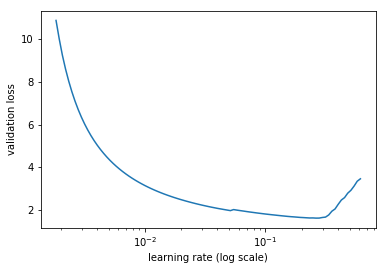

In [23]:
learner.sched.plot()

In [ ]:
learner.fit(1e-3, n_cycle=1)

In [23]:
for i, layer in enumerate(learner.model.children()):
    if i>5: layer.unfreeze()
    else: layer.freeze()

In [24]:
learner.fit(1e-3, n_cycle=2)
learner.fit(1e-3, n_cycle=3, cycle_mult=2)
learner.save("resnext50_13Oct_with_WeightedRandomSampler_unfreeze_5+")

epoch      trn_loss   val_loss   accuracy                   
    0      1.155459   1.099235   0.327059  
    1      1.109083   1.098679   0.334706                   



epoch      trn_loss   val_loss   accuracy                   
    0      1.119507   1.098541   0.339412  
    1      1.185286   1.098354   0.344118                   
    2      1.142749   1.098595   0.333824                   
    3      457.900398 1.100183   0.321176                       
    4      9130.295178 1.099121   0.333529                      
    5      1135.796674 1.098496   0.338235                      
    6      221.06289  1.098559   0.344412                      



In [20]:
learner.load("resnext50_13Oct_with_WeightedRandomSampler_unfreeze_5+")

In [27]:
def showFrame():
    for x,y in trainLoader:
        for i in range(len(x)):
            yield (x[i],y[i])
        break
gen=showFrame()

2


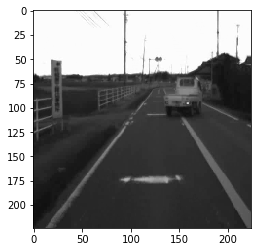

In [91]:
x,y=next(iter(gen))
x=x.cpu().numpy().astype("uint8")
x=np.moveaxis(x,0, 2)
print(y.cpu().numpy())
plt.imshow(x)

In [21]:
#Compare wrong labels and right labels with corrosponding groundtruth
for x,y in validLoader:
    x=x.to(device)
    y=y.to(device)
    pred=(learner.model(x))
    print(accuracy(pred, y))
    pred=F.argmax(pred, dim=1)
    y=y.cpu().numpy()
    pred=pred.cpu().numpy()
    print([(i,j) for i,j in zip(y,pred) if i!=j])
    print([(i,j) for i,j in zip(y,pred) if i==j])
    break

tensor(0.2500, device='cuda:0')
[(2, 0), (0, 1), (2, 0), (1, 2), (1, 2), (0, 1), (1, 2), (0, 1), (1, 0), (0, 2), (2, 0), (0, 2), (2, 1), (0, 2), (2, 0), (0, 2), (0, 2), (2, 1), (1, 2), (2, 0), (2, 1), (1, 0), (2, 0), (0, 2)]
[(2, 2), (2, 2), (2, 2), (2, 2), (0, 0), (2, 2), (2, 2), (2, 2)]


In [22]:
#Unfreezing All layers
for layer in learner.model.children():
    layer.unfreeze()

In [ ]:
learner.fit(2e-4, n_cycle=1)

In [23]:
def showFrame(vidName):
    frames=np.load(vidName)
    for i,frame in enumerate(frames):
      if i%10==0:
        frame=frame.squeeze()
        if len(frame.shape)==2:frame=np.dstack((frame,frame,frame))
    #     print(frame.shape)
        label=get_label(vidName, i)
        print(label)
        plt.imshow(frame)
        yield None
x=showFrame(rightVids[4])

In [36]:
def showResults():
    for x,y in validLoader:
        x=x.to(device)
        y=y.to(device)
        pred=(learner.model(x))
        y=y.cpu().numpy()
        pred=pred.detach().cpu().numpy()
        x=np.moveaxis(x.cpu().numpy(), 1, 3)
        
        print(x.shape)
        for i,yi in enumerate(y):
            print(f"GT Label: {yi}    Prediction:{pred[i]}")
            xi=x[i]
            xi-=xi.min()
            xi/=xi.max()
            xi*=255
            xi=xi.astype("uint8")
            plt.imshow(xi)
            yield
        break

In [37]:
doit=iter(showResults())

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f38cc07d5f8>>
Traceback (most recent call last):
  File "/home/sufiyan/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/sufiyan/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/sufiyan/anaconda3/envs/fastai/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/sufiyan/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/sufiyan/anaconda3/envs/fastai/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/sufiyan/anaconda3/envs/fastai/lib

GT Label: 2    Prediction:[0.26059 0.35676 0.38264]


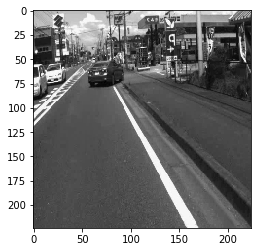

In [51]:
next(doit)